In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import tqdm
from einops import rearrange, repeat
import numpy as np
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device
import matplotlib.pyplot as plt
import seaborn as sns

from case_studies.dc2_mdt.utils.diffusion_forcing import DiffusionForcing
from case_studies.dc2_mdt.utils.new_simulate_image import ImageSimulator
from case_studies.dc2_mdt.utils.gaussian_diffusion import get_named_beta_schedule
from case_studies.dc2_mdt.utils.resample import create_named_schedule_sampler

In [3]:
image_size = 8
max_objects = 2
image_normalize_strategy = "linear_scale"

## RML

In [4]:
class FourierMLP(nn.Module):
    def __init__(self, data_shape, num_layers, hidden_ch):
        super().__init__()
        self.data_shape = [data_shape]

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )  # (1, hidden)
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])  # (1, hidden)
        # self.input_embed = nn.Sequential(
        #     nn.Linear(1, hidden_ch),
        #     nn.GELU(),
        #     nn.Linear(hidden_ch, hidden_ch)
        # )
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.image_embed = nn.Sequential(
            nn.Linear(image_size * image_size, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.layers = nn.Sequential(
            nn.Linear(hidden_ch + hidden_ch * int(np.prod(data_shape)), hidden_ch), 
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(hidden_ch, int(np.prod(data_shape))),
        )

    def forward(self, x, t, image):
        assert x.shape == t.shape
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.flatten().float().unsqueeze(1)) + self.timestep_phase
        ).view(*t.shape, -1)
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.flatten().float().unsqueeze(1)) + self.timestep_phase
        ).view(*t.shape, -1)
        embed_t = self.timestep_embed(torch.cat([sin_embed_t, cos_embed_t], dim=-1))
        # embed_xt = self.input_embed(x.flatten(1).unsqueeze(-1))
        embed_image = self.image_embed(image.flatten(1))
        out = self.layers(
            torch.cat([(x.unsqueeze(-1) + embed_t).flatten(1), embed_image], dim=-1)
        )
        return out.view(x.shape)

In [5]:
# class SimpleMLP(nn.Module):
#     def __init__(self, data_shape, num_layers, hidden_ch):
#         super().__init__()
#         self.data_shape = [data_shape]
#         data_dim_prod = int(np.prod(data_shape))

#         self.input_embed = nn.Sequential(
#             nn.Linear(data_dim_prod, hidden_ch),
#             nn.GELU(),
#             nn.Linear(hidden_ch, hidden_ch)
#         )
#         self.timestep_embed = nn.Sequential(
#             nn.Linear(data_dim_prod, hidden_ch),
#             nn.GELU(),
#             nn.Linear(hidden_ch, hidden_ch),
#         )
#         self.image_embed = nn.Sequential(
#             nn.Linear(image_size * image_size, hidden_ch),
#             nn.GELU(),
#             nn.Linear(hidden_ch, hidden_ch)
#         )
#         self.layers = nn.Sequential(
#             nn.Linear(hidden_ch * 3, hidden_ch), 
#             nn.GELU(),
#             *[
#                 nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
#                 for _ in range(num_layers)
#             ],
#             nn.Linear(hidden_ch, data_dim_prod),
#         )

#     def forward(self, x, t, image):
#         assert x.shape == t.shape
#         embed_t = self.timestep_embed(t.float().flatten(1))
#         embed_xt = self.input_embed(x.flatten(1))
#         embed_image = self.image_embed(image.flatten(1))
#         out = self.layers(
#             torch.cat([embed_t, embed_xt, embed_image], dim=-1)
#         )
#         return out.view(x.shape)

In [6]:
device = torch.device("cuda:6")
batch_size = 1024
training_time_steps = 1000
training_iters = 20_000
ddim_eta = 0.0  # use 0.0 for better results when max_objects >= 2
log_freq = 500
seed = 1201023
pytorch_lightning.seed_everything(seed)

Seed set to 1201023


1201023

In [7]:
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=max_objects,
                                 psf_stdev=1.0,
                                 flux_alpha=10.0,
                                 flux_beta=0.01,
                                 pad=0,
                                 always_max_count=False,
                                 constant_locs=False,
                                 coadd_images=True).to(device=device)

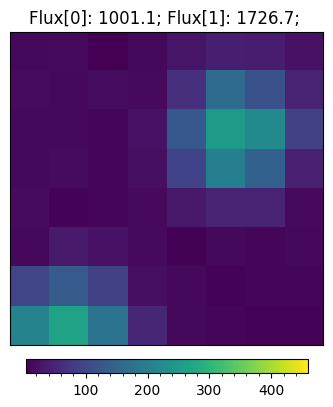

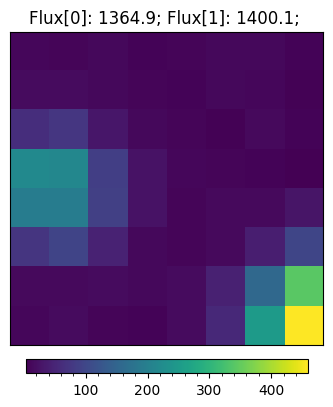

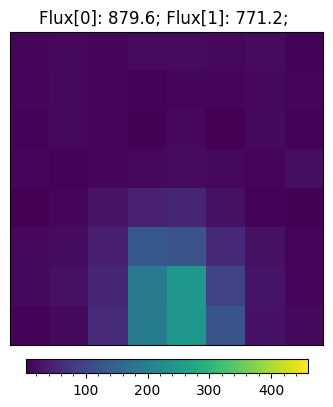

In [8]:
sim_out = image_simulator.generate(3, seed=7272)
img_min = sim_out["images"].min()
img_max = sim_out["images"].max()
for sub_img, flux in zip(sim_out["images"], sim_out["fluxes"]):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    im = ax.imshow(sub_img.cpu(), vmin=img_min, vmax=img_max)
    ax.set_xticks([])
    ax.set_yticks([])
    if flux.shape[0] == 1:
        ax.set_title(f"Flux: {flux.item():.1f}")
    else:
        t = ""
        for i, f in enumerate(flux):
            t += f"Flux[{i}]: {f.item():.1f}; "
        ax.set_title(t)
    cb = fig.colorbar(im, ax=ax, 
                      location="bottom", shrink=0.6,
                      anchor=(0.5, 2.0))
    cb.minorticks_on()
    fig.tight_layout()
    fig.show()

In [9]:
training_diffusion = DiffusionForcing(betas=get_named_beta_schedule("linear", training_time_steps))
sampling_diffusion = training_diffusion

In [10]:
my_net = FourierMLP(data_shape=[2, 4,], 
                    num_layers=8, 
                    hidden_ch=64).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [11]:
# max_flux_boundary = 2000.0
# def encode_flux(flux: torch.Tensor):
#     assert flux.min() >= 0.0
#     flux = flux.clamp(max=max_flux_boundary)
#     return (torch.log1p(flux) / torch.log1p(torch.tensor(max_flux_boundary))) * 2 - 1

# def decode_flux(flux_minus1_to_1: torch.Tensor):
#     assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
#     return torch.expm1((flux_minus1_to_1 + 1) / 2 * torch.log1p(torch.tensor(max_flux_boundary)))

In [12]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    flux = flux.clamp(max=max_flux_boundary)
    return (flux / max_flux_boundary) * 2 - 1

def decode_flux(flux_minus1_to_1: torch.Tensor):
    assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
    return (flux_minus1_to_1 + 1) / 2 * max_flux_boundary

In [13]:
def encode_x_start(catalog):
    n_sources = catalog["counts"]  # (b, )
    locs = catalog["locs"]  # (b, m, 2)
    fluxes = catalog["fluxes"].unsqueeze(-1)  # (b, m, 1)
    n_sources = (n_sources.unsqueeze(-1) >= torch.arange(1, locs.shape[1] + 1, device=locs.device)).unsqueeze(-1)  # (b, m, 1)
    x_start = torch.cat([n_sources * 2 - 1, locs / image_size * 2 - 1, encode_flux(fluxes)], dim=-1)  # (b, m, 4)
    sorted_index = x_start[..., -1].argsort(dim=-1, descending=True)  # (b, m)
    return torch.take_along_dim(x_start, repeat(sorted_index, "... -> ... r", r=4), dim=-2)  # (b, m, 4)

In [14]:
def decode_x_start(output_x_start):
    n_sources = output_x_start[..., 0] > 0.0  # (b, m)
    locs = (output_x_start[..., 1:3] + 1) / 2 * image_size  # (b, m, 2)
    fluxes = decode_flux(output_x_start[..., 3])  # (b, m)
    return {
        "counts": n_sources.sum(dim=-1),
        "n_sources": n_sources.int(),
        "locs": locs,
        "fluxes": fluxes,
    }

In [15]:
def normalize_image(input_image):
    match image_normalize_strategy:
        case "none":
            output_image = input_image
        case "log":
            output_image = torch.log1p(input_image)
        case "linear_scale":
            output_image = input_image / 1000
        case _:
            raise NotImplementedError()
    return output_image

In [16]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    x_start = encode_x_start(catalog)
    t = torch.randint_like(x_start, low=0, high=training_time_steps, dtype=torch.long)
    batch_sample_weights = torch.ones((batch_size, ), device=device)
    batch_loss_weights = None
    input_image = catalog["images"]  # (b, h, w)
    input_image = normalize_image(input_image)
    train_loss_args = {
        "model": my_net,
        "x_start": x_start,
        "t": t,
        "loss_weights": batch_loss_weights
    }
    loss = training_diffusion.training_losses(**train_loss_args, 
                                              model_kwargs={"image": input_image})["loss"]
    loss = (loss * batch_sample_weights).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

  3%|▎         | 512/20000 [00:07<04:28, 72.49it/s]

[500/20000] loss: 2.190e-01


  5%|▌         | 1010/20000 [00:14<04:29, 70.43it/s]

[1000/20000] loss: 1.959e-01


  8%|▊         | 1514/20000 [00:21<04:12, 73.20it/s]

[1500/20000] loss: 1.763e-01


 10%|█         | 2010/20000 [00:28<04:05, 73.37it/s]

[2000/20000] loss: 1.064e-01


 13%|█▎        | 2511/20000 [00:35<04:08, 70.33it/s]

[2500/20000] loss: 9.592e-02


 15%|█▌        | 3007/20000 [00:42<03:53, 72.90it/s]

[3000/20000] loss: 8.052e-02


 18%|█▊        | 3510/20000 [00:49<03:51, 71.27it/s]

[3500/20000] loss: 7.142e-02


 20%|██        | 4010/20000 [00:56<03:47, 70.14it/s]

[4000/20000] loss: 8.165e-02


 23%|██▎       | 4508/20000 [01:03<03:32, 73.05it/s]

[4500/20000] loss: 7.136e-02


 25%|██▌       | 5012/20000 [01:10<03:26, 72.47it/s]

[5000/20000] loss: 6.525e-02


 28%|██▊       | 5509/20000 [01:17<03:29, 69.09it/s]

[5500/20000] loss: 5.344e-02


 30%|███       | 6009/20000 [01:24<03:21, 69.44it/s]

[6000/20000] loss: 6.307e-02


 33%|███▎      | 6507/20000 [01:31<03:08, 71.71it/s]

[6500/20000] loss: 6.217e-02


 35%|███▌      | 7012/20000 [01:38<03:05, 69.87it/s]

[7000/20000] loss: 5.569e-02


 38%|███▊      | 7509/20000 [01:45<02:52, 72.37it/s]

[7500/20000] loss: 5.991e-02


 40%|████      | 8014/20000 [01:52<02:42, 73.57it/s]

[8000/20000] loss: 5.687e-02


 43%|████▎     | 8512/20000 [01:59<02:36, 73.43it/s]

[8500/20000] loss: 4.838e-02


 45%|████▌     | 9008/20000 [02:06<02:29, 73.31it/s]

[9000/20000] loss: 5.091e-02


 48%|████▊     | 9512/20000 [02:12<02:23, 73.11it/s]

[9500/20000] loss: 5.396e-02


 50%|█████     | 10008/20000 [02:19<02:23, 69.53it/s]

[10000/20000] loss: 5.024e-02


 53%|█████▎    | 10509/20000 [02:26<02:09, 73.33it/s]

[10500/20000] loss: 4.797e-02


 55%|█████▌    | 11007/20000 [02:33<02:08, 69.75it/s]

[11000/20000] loss: 5.598e-02


 58%|█████▊    | 11507/20000 [02:40<02:01, 69.78it/s]

[11500/20000] loss: 4.161e-02


 60%|██████    | 12010/20000 [02:47<01:49, 72.99it/s]

[12000/20000] loss: 5.275e-02


 63%|██████▎   | 12513/20000 [02:54<01:42, 73.24it/s]

[12500/20000] loss: 4.555e-02


 65%|██████▌   | 13014/20000 [03:01<01:40, 69.78it/s]

[13000/20000] loss: 4.629e-02


 68%|██████▊   | 13507/20000 [03:08<01:33, 69.33it/s]

[13500/20000] loss: 4.377e-02


 70%|███████   | 14008/20000 [03:16<01:18, 76.51it/s]

[14000/20000] loss: 5.281e-02


 73%|███████▎  | 14512/20000 [03:22<01:14, 73.20it/s]

[14500/20000] loss: 4.795e-02


 75%|███████▌  | 15008/20000 [03:29<01:08, 73.41it/s]

[15000/20000] loss: 4.785e-02


 78%|███████▊  | 15512/20000 [03:36<01:01, 72.87it/s]

[15500/20000] loss: 3.859e-02


 80%|████████  | 16008/20000 [03:43<00:54, 72.98it/s]

[16000/20000] loss: 3.735e-02


 83%|████████▎ | 16512/20000 [03:50<00:47, 73.38it/s]

[16500/20000] loss: 3.587e-02


 85%|████████▌ | 17008/20000 [03:57<00:42, 70.15it/s]

[17000/20000] loss: 3.973e-02


 88%|████████▊ | 17512/20000 [04:04<00:34, 72.95it/s]

[17500/20000] loss: 3.576e-02


 90%|█████████ | 18013/20000 [04:11<00:28, 69.84it/s]

[18000/20000] loss: 3.730e-02


 93%|█████████▎| 18510/20000 [04:18<00:21, 69.33it/s]

[18500/20000] loss: 3.824e-02


 95%|█████████▌| 19014/20000 [04:25<00:13, 73.16it/s]

[19000/20000] loss: 4.596e-02


 98%|█████████▊| 19510/20000 [04:32<00:06, 73.67it/s]

[19500/20000] loss: 4.520e-02


100%|██████████| 20000/20000 [04:38<00:00, 71.76it/s]

[20000/20000] loss: 4.442e-02


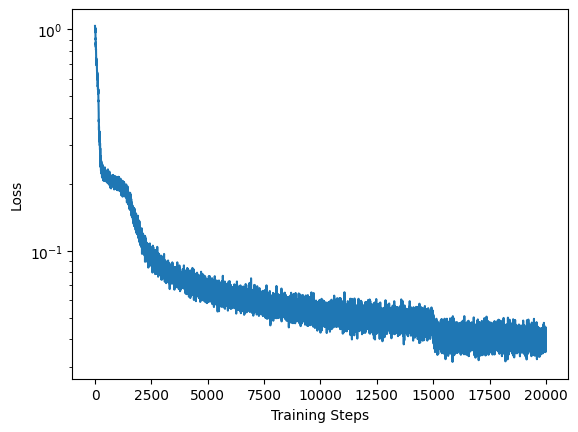

In [17]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [18]:
def pad_t(input_t: torch.Tensor, pad_front_num, pad_rear_num):
    assert input_t.ndim == 1
    pad_front_v = torch.full((pad_front_num, ), fill_value=input_t[0].item(), device=input_t.device)
    pad_rear_v = torch.full((pad_rear_num, ), fill_value=input_t[-1].item(), device=input_t.device)
    return torch.cat([pad_front_v, input_t, pad_rear_v], dim=0)

In [19]:
# base_k_vec = torch.linspace(0, training_time_steps - 1, 50).int().flip(dims=(0,))
# pad_num = 50
# first_source_k_vec = repeat(pad_t(base_k_vec, pad_front_num=0, pad_rear_num=pad_num), "k -> k b f", b=batch_size, f=4)
# second_source_k_vec = repeat(pad_t(base_k_vec, pad_front_num=pad_num, pad_rear_num=0), "k -> k b f", b=batch_size, f=4)
# k_matrix = torch.stack([first_source_k_vec, second_source_k_vec], dim=-2).to(device=device)

In [20]:
# base_k_vec = torch.linspace(0, training_time_steps - 1, 30).int().flip(dims=(0,))
# n_sources_k_vec = pad_t(base_k_vec, pad_front_num=0, pad_rear_num=60)
# locs_y_k_vec = pad_t(base_k_vec, pad_front_num=60, pad_rear_num=0)
# locs_x_k_vec = pad_t(base_k_vec, pad_front_num=60, pad_rear_num=0)
# flux_k_vec = pad_t(base_k_vec, pad_front_num=30, pad_rear_num=30)
# k_matrix = repeat(torch.stack([n_sources_k_vec, locs_y_k_vec, locs_x_k_vec, flux_k_vec], dim=-1),
#                   "k f -> k b m f", b=batch_size, m=max_objects).to(device=device)

In [21]:
# base_k_vec = torch.linspace(0, training_time_steps - 1, 30).int().flip(dims=(0,))
# n_sources_k_vec = pad_t(base_k_vec, pad_front_num=0, pad_rear_num=0)
# locs_y_k_vec = pad_t(base_k_vec, pad_front_num=0, pad_rear_num=0)
# locs_x_k_vec = pad_t(base_k_vec, pad_front_num=0, pad_rear_num=0)
# flux_k_vec = pad_t(base_k_vec, pad_front_num=0, pad_rear_num=0)
# k_matrix = repeat(torch.stack([n_sources_k_vec, locs_y_k_vec, locs_x_k_vec, flux_k_vec], dim=-1),
#                   "k f -> k b m f", b=batch_size, m=max_objects).to(device=device)

In [22]:
base_k_vec = torch.linspace(0, training_time_steps - 1, 30).int().flip(dims=(0,))
n_sources_k_vec = pad_t(base_k_vec, pad_front_num=0, pad_rear_num=30)
locs_y_k_vec = pad_t(base_k_vec, pad_front_num=30, pad_rear_num=0)
locs_x_k_vec = pad_t(base_k_vec, pad_front_num=30, pad_rear_num=0)
flux_k_vec = pad_t(base_k_vec, pad_front_num=30, pad_rear_num=0)
k_matrix = repeat(torch.stack([n_sources_k_vec, locs_y_k_vec, locs_x_k_vec, flux_k_vec], dim=-1),
                  "k f -> k b m f", b=batch_size, m=max_objects).to(device=device)

In [23]:
k_matrix.shape

torch.Size([60, 1024, 2, 4])

In [24]:
my_net.eval()
val_true_cat = []
val_est_cat = []
with torch.inference_mode():
    for i in tqdm.tqdm(list(range(1000))):
        val_catalog = image_simulator.generate(batch_size=batch_size, seed=seed)
        input_image = normalize_image(val_catalog["images"])
        val_catalog = decode_x_start(encode_x_start(val_catalog))
        val_true_cat.append(move_data_to_device(val_catalog, "cpu"))
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (batch_size, max_objects, 4),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image}
        }
        sample = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, 
                                                     k_matrix=k_matrix, 
                                                     eta=ddim_eta)
        val_est_cat.append(move_data_to_device(decode_x_start(sample), "cpu"))

100%|██████████| 1000/1000 [01:27<00:00, 11.38it/s]


In [25]:
diffusion_pred_ns = []
diffusion_true_ns = []
diffusion_pred_locs = []
diffusion_true_locs = []
diffusion_pred_fluxes = []
diffusion_true_fluxes = []
for ec, tc in zip(val_est_cat, val_true_cat, strict=True):
    diffusion_pred_ns.append(ec["counts"])
    diffusion_true_ns.append(tc["counts"])
    diffusion_pred_locs.append(ec["locs"])
    diffusion_true_locs.append(tc["locs"])
    diffusion_pred_fluxes.append(ec["fluxes"])
    diffusion_true_fluxes.append(tc["fluxes"])
diffusion_pred_ns = torch.cat(diffusion_pred_ns, dim=0)
diffusion_true_ns = torch.cat(diffusion_true_ns, dim=0)
diffusion_pred_locs = torch.cat(diffusion_pred_locs, dim=0)
diffusion_true_locs = torch.cat(diffusion_true_locs, dim=0)
diffusion_pred_fluxes = torch.cat(diffusion_pred_fluxes, dim=0)
diffusion_true_fluxes = torch.cat(diffusion_true_fluxes, dim=0)

In [26]:
diffusion_pred_ns.shape, diffusion_true_ns.shape

(torch.Size([1024000]), torch.Size([1024000]))

In [27]:
diffusion_pred_locs.shape, diffusion_true_locs.shape

(torch.Size([1024000, 2, 2]), torch.Size([1024000, 2, 2]))

In [28]:
diffusion_pred_fluxes.shape, diffusion_true_fluxes.shape

(torch.Size([1024000, 2]), torch.Size([1024000, 2]))

In [29]:
def plot_cm(d_pred_bin_index, d_true_bin_index, bin_num, bin_labels, axis_label):
    d_cm = torch.zeros(bin_num, bin_num, dtype=torch.int)
    for ri in range(d_cm.shape[0]):
        for ci in range(d_cm.shape[1]):
            d_cm[ri, ci] = ((d_pred_bin_index == ri) & (d_true_bin_index == ci)).sum()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(d_cm,
                annot=True,
                fmt="d", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=ax)
    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Pred {axis_label}")
    ax.set_title("Diffusion")
    fig.show()

    # fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
    #             annot=True,
    #             fmt=".2f", cmap="Greens", cbar=False,
    #             xticklabels=bin_labels,
    #             yticklabels=bin_labels,
    #             ax=ax)
    # ax.set_xlabel(f"True {axis_label}")
    # ax.set_ylabel(f"Pred {axis_label}")
    # ax.set_title("Diffusion (CM in Percent)")
    # fig.show()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1)).abs(),
                annot=(d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
                fmt=".2f", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=ax)
    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Pred {axis_label}")
    ax.set_title("Diffusion (Asymmetry Factor)")
    fig.show()

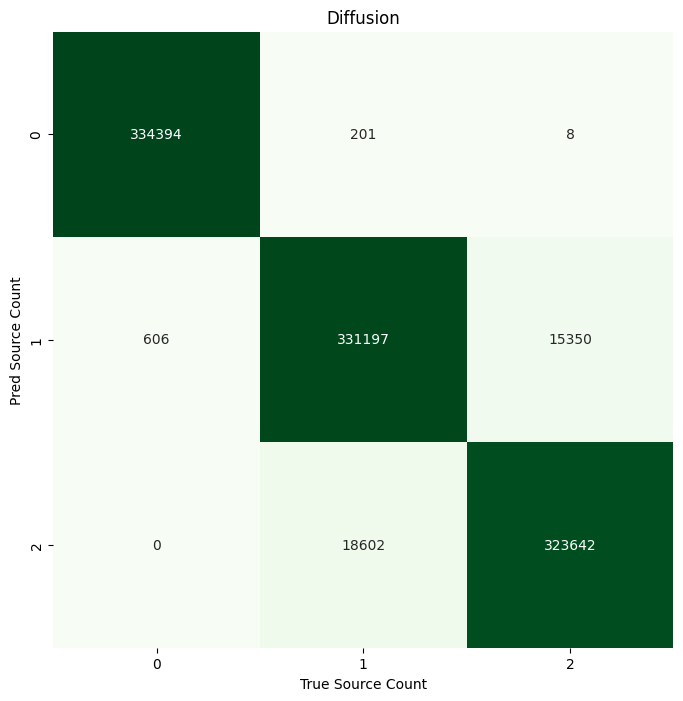

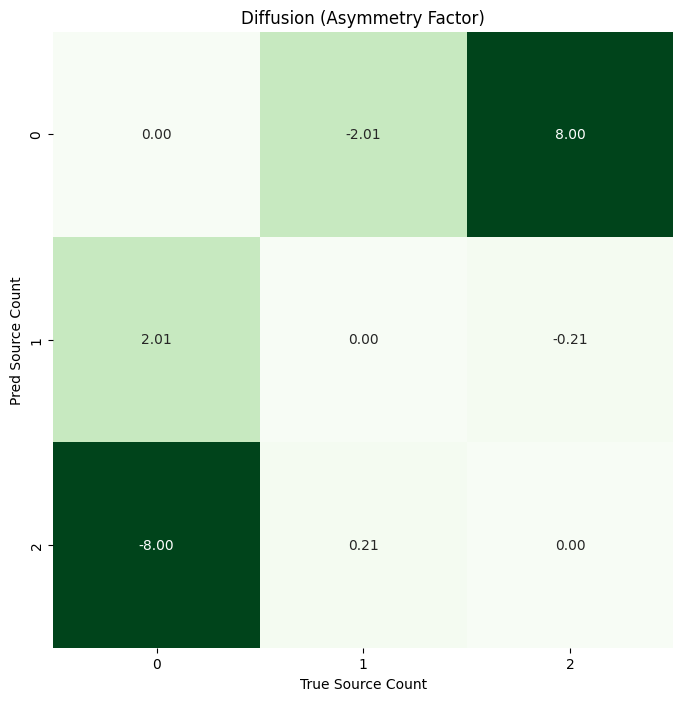

In [30]:
plot_cm(diffusion_pred_ns, diffusion_true_ns, 
        bin_num=3, bin_labels=list(range(3)), axis_label="Source Count")

In [31]:
def inclusive_bucektize(input_t, boundary):
    new_boundary = boundary.clone()
    new_boundary[0] -= 1e-3
    new_boundary[-1] += 1e-3
    b_index = torch.bucketize(input_t, new_boundary)
    assert (b_index > 0).all()
    assert (b_index < new_boundary.shape[0]).all()
    return b_index - 1

/tmp/ipykernel_3166106/3313582822.py:5: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)
  b_index = torch.bucketize(input_t, new_boundary)


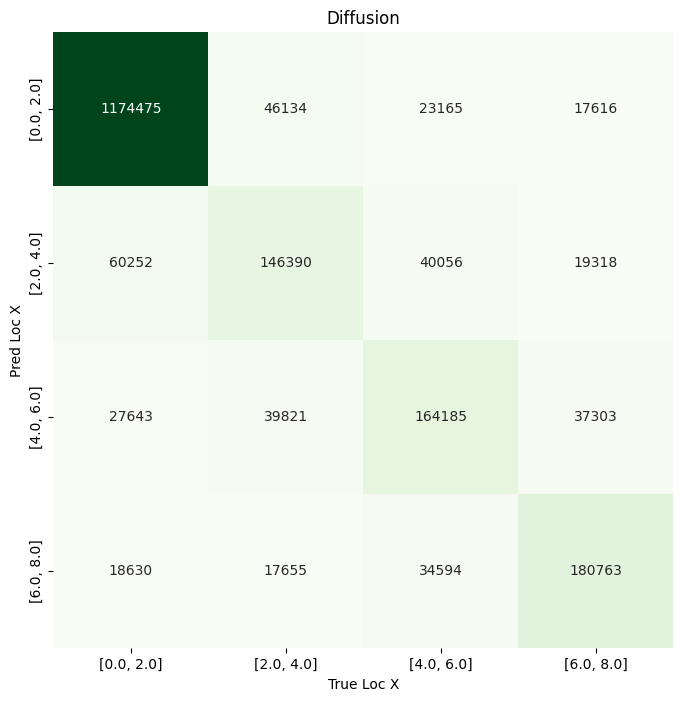

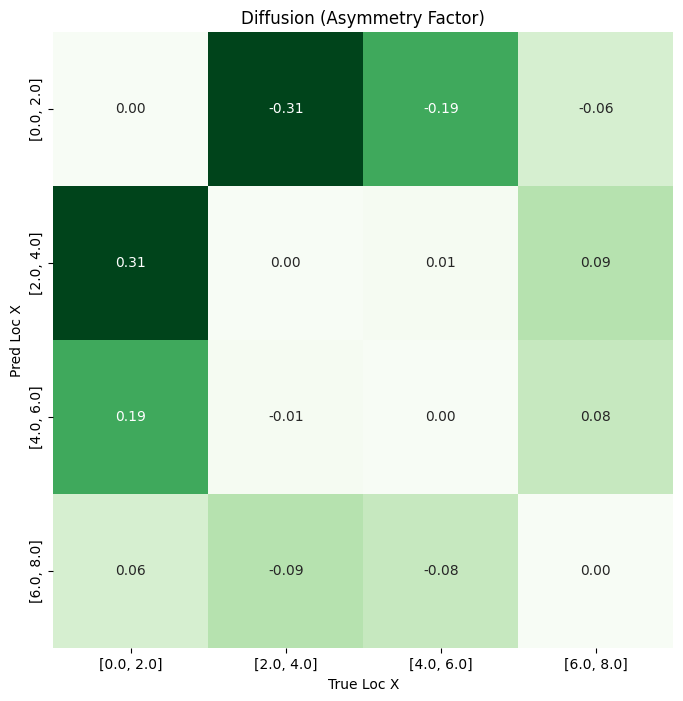

In [32]:
locs_bin_boundary = torch.linspace(0.0, 8.0, 5)
d_pred_locs_x_bin_index = inclusive_bucektize(diffusion_pred_locs[..., 1].flatten(), locs_bin_boundary)
d_true_locs_x_bin_index = inclusive_bucektize(diffusion_true_locs[..., 1].flatten(), locs_bin_boundary)
plot_cm(d_pred_locs_x_bin_index, d_true_locs_x_bin_index, 
        bin_num=4, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(locs_bin_boundary[:-1], 
                                                   locs_bin_boundary[1:])], 
        axis_label="Loc X")

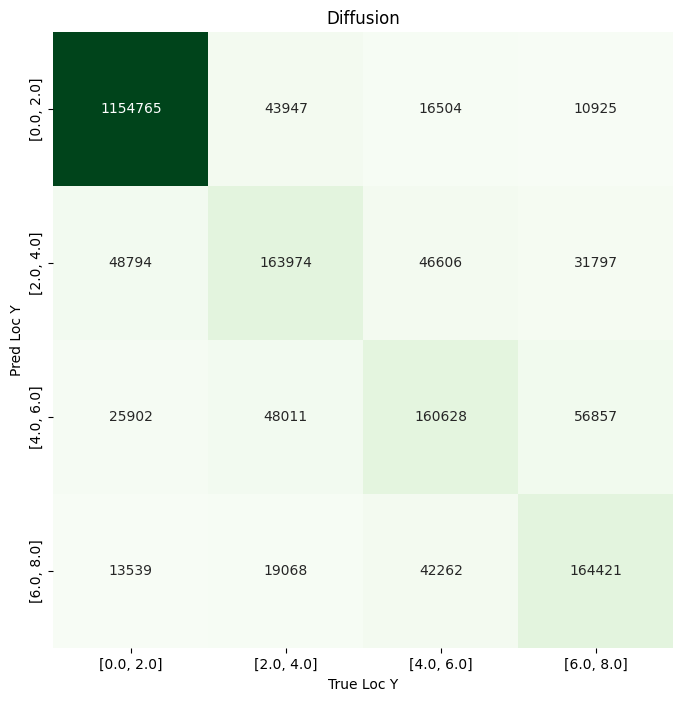

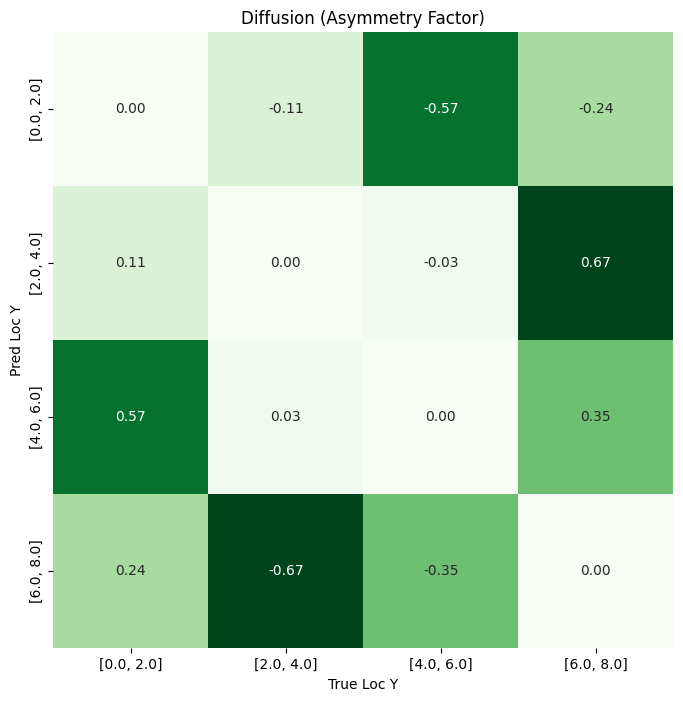

In [33]:
locs_bin_boundary = torch.linspace(0.0, 8.0, 5)
d_pred_locs_y_bin_index = inclusive_bucektize(diffusion_pred_locs[..., 0].flatten(), locs_bin_boundary)
d_true_locs_y_bin_index = inclusive_bucektize(diffusion_true_locs[..., 0].flatten(), locs_bin_boundary)
plot_cm(d_pred_locs_y_bin_index, d_true_locs_y_bin_index, 
        bin_num=4, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(locs_bin_boundary[:-1], 
                                                   locs_bin_boundary[1:])], 
        axis_label="Loc Y")

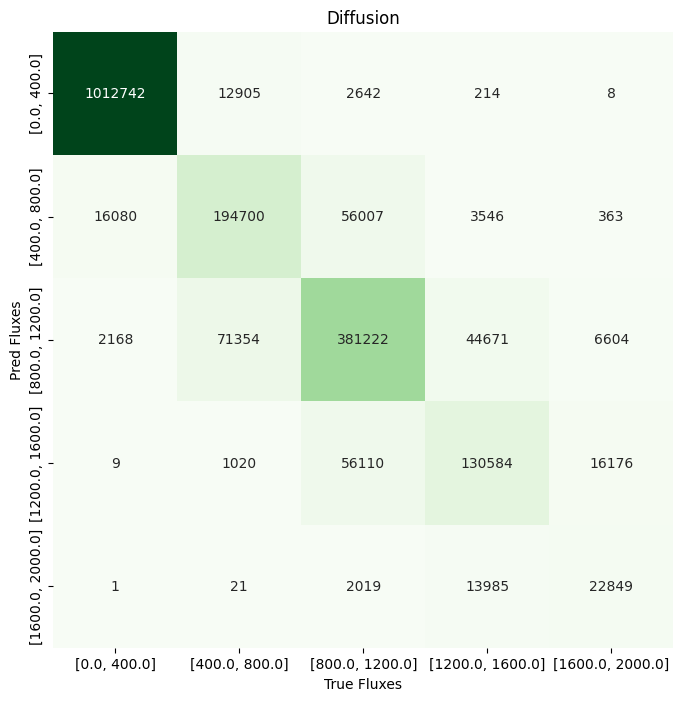

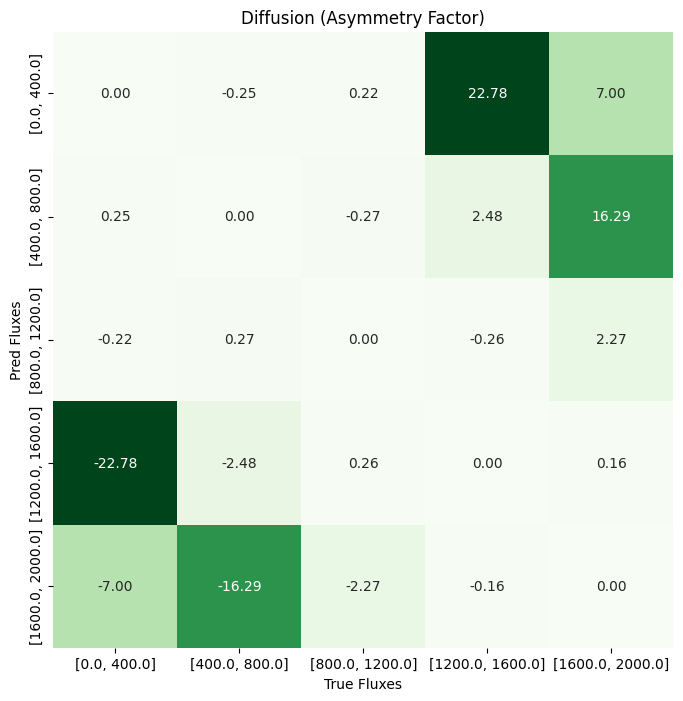

In [34]:
fluxes_bin_boundary = torch.linspace(0.0, 2000.0, 6)
d_pred_fluxes_bin_index = inclusive_bucektize(diffusion_pred_fluxes.flatten(), fluxes_bin_boundary)
d_true_fluxes_bin_index = inclusive_bucektize(diffusion_true_fluxes.flatten(), fluxes_bin_boundary)
plot_cm(d_pred_fluxes_bin_index, d_true_fluxes_bin_index, 
        bin_num=5, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(fluxes_bin_boundary[:-1], 
                                                   fluxes_bin_boundary[1:])], 
        axis_label="Fluxes")

In [35]:
my_cat = {
    "counts": torch.ones(1, device=device, dtype=torch.int) * 1,
    "locs": torch.tensor([[3.0, 3.0], [0.0, 0.0]], device=device).unsqueeze(0),
    "fluxes": torch.tensor([1500.0, 0.0], device=device).unsqueeze(0)
}

In [36]:
my_cat = image_simulator._generate_by_catalog(my_cat)

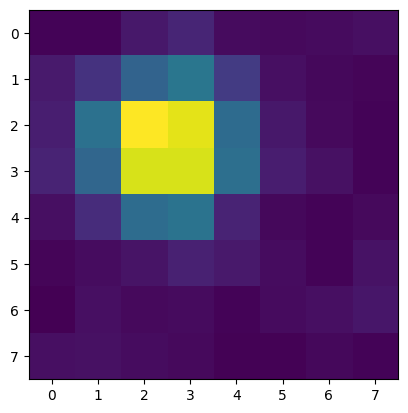

In [37]:
plt.imshow(my_cat["images"][0].cpu())
plt.show()

In [38]:
input_image = normalize_image(my_cat["images"])
traces = []
with torch.inference_mode():
    for i in tqdm.tqdm(list(range(100))):
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (1, max_objects, 4),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image}
        }
        _sample, inter = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, 
                                                             k_matrix=k_matrix[:, 0:1],
                                                             eta=ddim_eta, 
                                                             return_intermediate=True)
        traces.append([decode_x_start(i) for i in inter])

100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


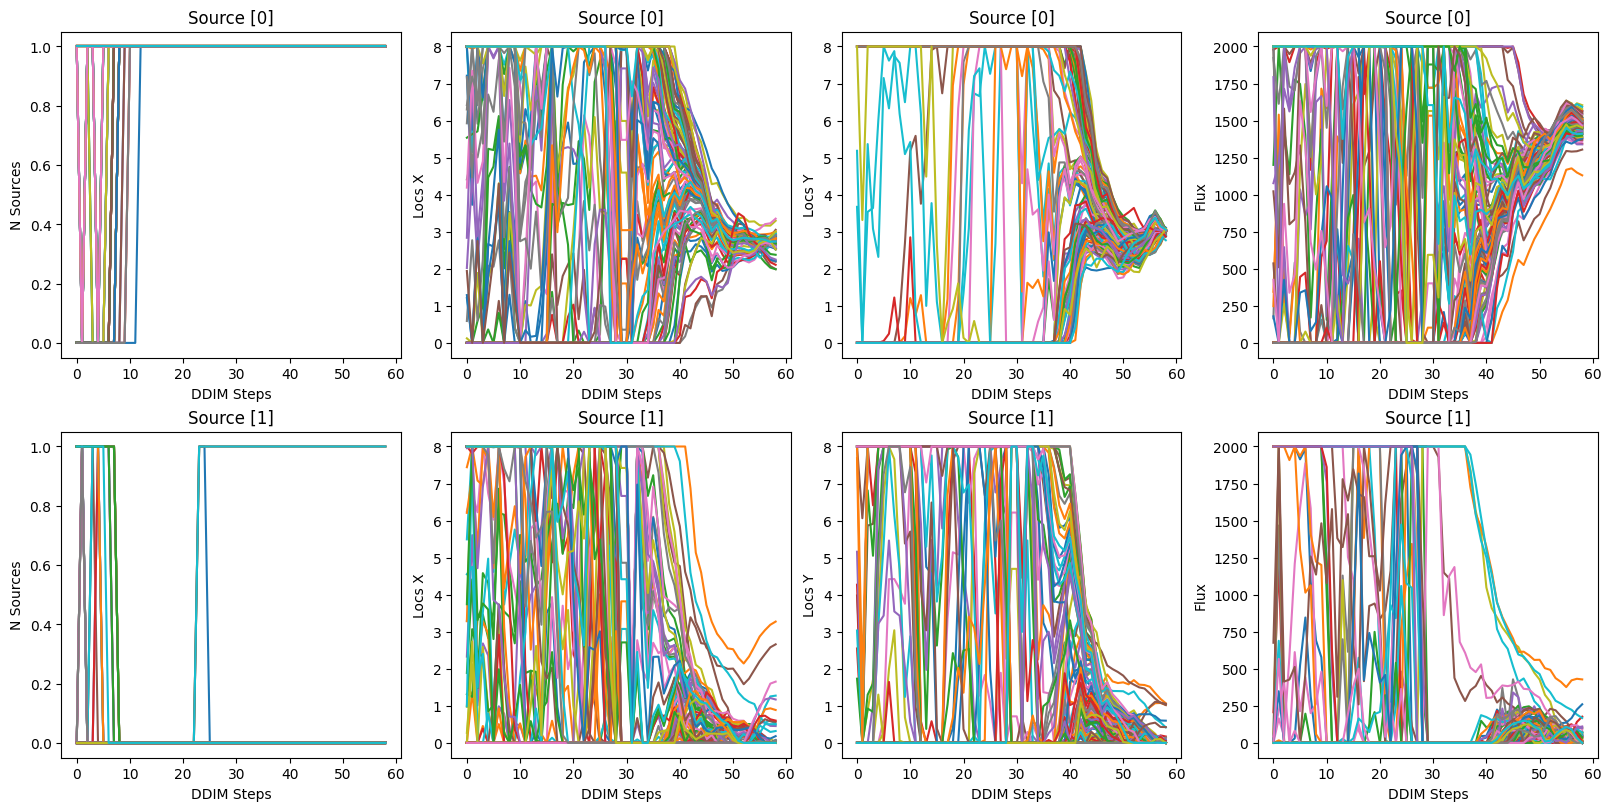

In [39]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
for t in traces:
    x = list(range(len(t)))
    for mi in range(2):
        axes[mi, 0].plot(x, [tt["n_sources"][0, mi].item() for tt in t])
        axes[mi, 0].set_ylabel("N Sources")
        axes[mi, 0].set_xlabel("DDIM Steps")
        axes[mi, 0].set_title(f"Source [{mi}]")
        axes[mi, 1].plot(x, [tt["locs"][0, mi, 1].item() for tt in t])
        axes[mi, 1].set_ylabel("Locs X")
        axes[mi, 1].set_xlabel("DDIM Steps")
        axes[mi, 1].set_title(f"Source [{mi}]")
        axes[mi, 2].plot(x, [tt["locs"][0, mi, 0].item() for tt in t])
        axes[mi, 2].set_ylabel("Locs Y")
        axes[mi, 2].set_xlabel("DDIM Steps")
        axes[mi, 2].set_title(f"Source [{mi}]")
        axes[mi, 3].plot(x, [tt["fluxes"][0, mi].item() for tt in t])
        axes[mi, 3].set_ylabel("Flux")
        axes[mi, 3].set_xlabel("DDIM Steps")
        axes[mi, 3].set_title(f"Source [{mi}]")
fig.show()    